In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from scipy.stats import norm, randint, uniform
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import Error

In [29]:
# Function to connect to the MySQL database
def create_db_connection(host_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

In [30]:
# Function to execute query
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as err:
        print(f"Error: '{err}'")

In [4]:
# Connect to the database
connection = create_db_connection("localhost", "root", "", "sales_predic_sys")

MySQL Database connection successful


In [5]:
# Fetch data from the database
query = "SELECT * FROM sales_data"
result = execute_query(connection, query)

In [6]:
# Convert the result to a pandas DataFrame
df = pd.DataFrame(result, columns=['sales_cat', 'net_value', 'year', 'month'])

In [7]:
# Close the database connection
connection.close()

In [8]:
# Continue with data preprocessing and model building
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'], format='%Y-%B')
df['month_num'] = df['date'].dt.month
df['year_num'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['is_holiday_season'] = ((df['month_num'] == 11) | (df['month_num'] == 12)).astype(int)
df['days_in_month'] = df['date'].dt.days_in_month

In [9]:
# Feature Engineering
df['year_month'] = df['date'].dt.to_period('M')
df['sales_growth'] = df.groupby('sales_cat')['net_value'].pct_change()
df['cumulative_sales'] = df.groupby('sales_cat')['net_value'].cumsum()
df['sales_ma_3'] = df.groupby('sales_cat')['net_value'].rolling(window=3).mean().reset_index(0, drop=True)
df['sales_ma_6'] = df.groupby('sales_cat')['net_value'].rolling(window=6).mean().reset_index(0, drop=True)
df['sales_ma_12'] = df.groupby('sales_cat')['net_value'].rolling(window=12).mean().reset_index(0, drop=True)

In [10]:
# Lag features and rolling mean features
for lag in [1, 3, 6, 12]:
    df[f'net_value_lag_{lag}'] = df.groupby('sales_cat')['net_value'].shift(lag)
for window in [3, 6, 12]:
    df[f'net_value_rolling_mean_{window}'] = df.groupby('sales_cat')['net_value'].rolling(window=window).mean().reset_index(0, drop=True)

In [11]:
le = LabelEncoder()
df['sales_cat_encoded'] = le.fit_transform(df['sales_cat'])
df.dropna(inplace=True)

In [12]:
# Define features and target
features = ['year_num', 'month_num', 'sales_cat_encoded', 'quarter', 'is_holiday_season', 'days_in_month',
            'net_value_lag_1', 'net_value_lag_3', 'net_value_lag_6', 'net_value_lag_12',
            'net_value_rolling_mean_3', 'net_value_rolling_mean_6', 'net_value_rolling_mean_12',
            'sales_growth', 'cumulative_sales', 'sales_ma_3', 'sales_ma_6', 'sales_ma_12']

In [13]:
# Split the data into training and testing sets
train_df = df[df['year_num'] < 2023]
test_df = df[df['year_num'] == 2023]

In [14]:
X_train = train_df[features]
y_train = train_df['net_value']
X_test = test_df[features]
y_test = test_df['net_value']

In [15]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [16]:
# Define the parameter space
param_distributions = {
    'regressor__n_estimators': randint(100, 500),
    'regressor__max_depth': randint(5, 30),
    'regressor__min_samples_split': randint(2, 20),
    'regressor__min_samples_leaf': randint(1, 10),
    'regressor__max_features': uniform(0.1, 0.9)
}

In [17]:
# Perform RandomizedSearchCV
tscv = TimeSeriesSplit(n_splits=5)
random_search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, 
                                   n_iter=50, cv=tscv, scoring='neg_mean_squared_error', 
                                   random_state=42, n_jobs=-1)

In [18]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('regressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'regressor__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A92DE88C20>,
                                        'regr...
                                        'regressor__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A92DE88A40>,
                                        'regressor__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A92DE889E0>,
                                        'regressor__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A92DE88320>},
                   random_state=42, scoring='neg_mean_squared_error')

In [19]:
# Get the best model
best_model = random_search.best_estimator_

In [20]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

In [21]:
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [22]:
print("Random Forest Performance on 2023 Test Data:")
print(f"MSE: {mse}")
print(f"R-squared: {r2}")

Random Forest Performance on 2023 Test Data:
MSE: 200360808901039.75
R-squared: 0.8227766620231818


In [23]:
# Prediction Intervals
def predict_with_intervals(model, X, y_true, percentile=95):
    y_pred = model.predict(X)
    sci = norm.ppf(percentile/100)
    residuals = y_true - y_pred
    std_resid = np.std(residuals)
    interval = sci * std_resid
    lower = y_pred - interval
    upper = y_pred + interval
    return y_pred, lower, upper

y_pred, lower, upper = predict_with_intervals(best_model, X_test, y_test)

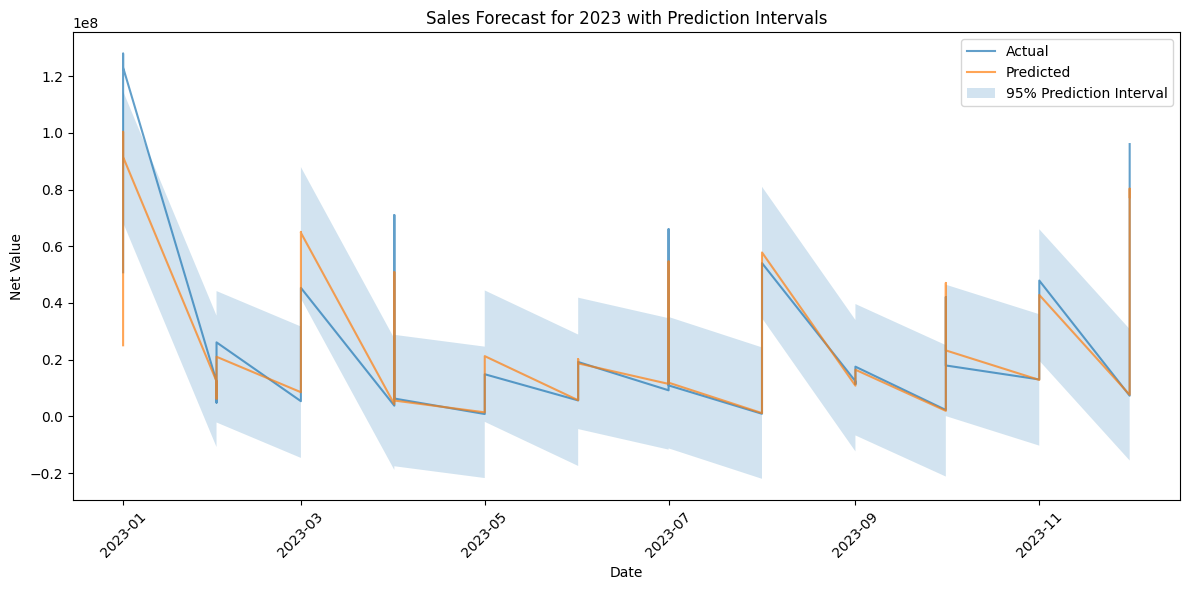

In [24]:
# Plot predictions with intervals for the test set (2023 data)
plt.figure(figsize=(12, 6))
plt.plot(test_df['date'], y_test, label='Actual', alpha=0.7)
plt.plot(test_df['date'], y_pred, label='Predicted', alpha=0.7)
plt.fill_between(test_df['date'], lower, upper, alpha=0.2, label='95% Prediction Interval')
plt.title('Sales Forecast for 2023 with Prediction Intervals')
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
# Function to predict net_value with intervals
def predict_net_value_with_intervals(year, month, sales_cat, percentile=95):
    input_df = pd.DataFrame({
        'year': [year],
        'month': [month],
        'sales_cat': [sales_cat]
    })

    # Preprocess input data
    input_df['date'] = pd.to_datetime(input_df['year'].astype(str) + '-' + input_df['month'], format='%Y-%B')
    input_df['month_num'] = input_df['date'].dt.month
    input_df['year_num'] = input_df['date'].dt.year
    input_df['quarter'] = input_df['date'].dt.quarter
    input_df['is_holiday_season'] = ((input_df['month_num'] == 11) | (input_df['month_num'] == 12)).astype(int)
    input_df['days_in_month'] = input_df['date'].dt.days_in_month
    input_df['sales_cat_encoded'] = le.transform(input_df['sales_cat'])

    # Add engineered features (you may need to adjust these based on available data)
    input_df['sales_growth'] = 0  # You may want to use an average or recent growth rate
    input_df['cumulative_sales'] = 0  # You may want to use the last known cumulative sales
    input_df['sales_ma_3'] = 0  # You may want to use the last known moving average
    input_df['sales_ma_6'] = 0
    input_df['sales_ma_12'] = 0

    for feature in features:
        if feature not in input_df.columns:
            input_df[feature] = 0  # or some appropriate default value

    input_features = input_df[features]

    prediction = best_model.predict(input_features)
    # For intervals, we'll use the std of residuals from the test set
    std_resid = np.std(y_test - best_model.predict(X_test))
    sci = norm.ppf(percentile/100)
    interval = sci * std_resid
    lower = prediction - interval
    upper = prediction + interval
    return prediction[0], lower[0], upper[0]

In [26]:
# Example usage
print("\nPredictions for 2024:")
print(predict_net_value_with_intervals(2024, 'January', 'Corporate'))
print(predict_net_value_with_intervals(2024, 'January', 'Retail'))
print(predict_net_value_with_intervals(2024, 'January', 'Show Rooms'))


Predictions for 2024:
(np.float64(269923.90457408054), np.float64(-22906506.660475925), np.float64(23446354.469624087))
(np.float64(304100.0771475846), np.float64(-22872330.48790242), np.float64(23480530.64219759))
(np.float64(386608.72018228995), np.float64(-22789821.844867717), np.float64(23563039.285232294))


In [27]:
# Example usage
print("\nPredictions for 2024:")
print(predict_net_value_with_intervals(2024, 'April', 'Corporate'))
print(predict_net_value_with_intervals(2024, 'April', 'Retail'))
print(predict_net_value_with_intervals(2024, 'April', 'Show Rooms'))


Predictions for 2024:
(np.float64(269585.3343561629), np.float64(-22906845.230693843), np.float64(23446015.89940617))
(np.float64(303761.5069296669), np.float64(-22872669.05812034), np.float64(23480192.07197967))
(np.float64(386270.1499643723), np.float64(-22790160.415085632), np.float64(23562700.71501438))
